In [17]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

In [19]:
data = pd.read_excel("data.xlsx")
dates = data["Date"]
values = data.iloc[:, 1].to_numpy()

In [21]:
#1.тренд
#добавляем константу для линейной регрессии
X = np.column_stack([np.ones(len(values)), np.arange(len(values))])
model = sm.OLS(values, X).fit()

In [23]:
trend = model.fittedvalues
t_stat = model.tvalues[1]  #t-статистика для линейного коэффициента
p_value = model.pvalues[1]  #p-value для линейного коэффициента
print(f"Трендовая составляющая: {trend[:5]}...")  #показываем первые 5 значений тренда
print(f"T-статистика: {t_stat}, P-value: {p_value}")
if p_value < 0.05:
    print("Тренд статистически значим.")
else:
    print("Тренд не статистически значим.")

Трендовая составляющая: [9.90214853 9.90261798 9.90308743 9.90355688 9.90402633]...
T-статистика: 5.301628880111855, P-value: 1.2158113937086306e-07
Тренд статистически значим.


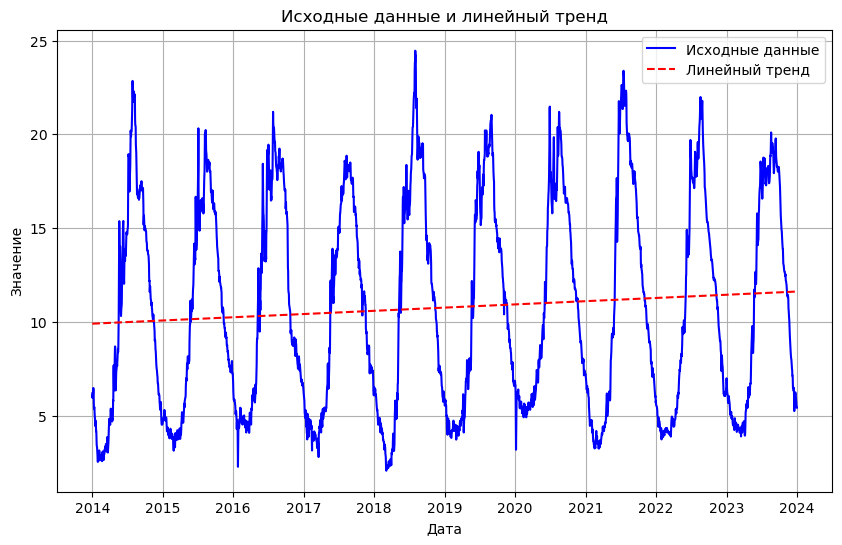

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(dates, values, label="Исходные данные", color='blue')
plt.plot(dates, trend, label="Линейный тренд", linestyle='--', color='red')
plt.title("Исходные данные и линейный тренд")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.legend()
plt.grid()
plt.show()

In [29]:
#3.гармонический анализ
N = len(values)
T = 1  #предположим, что данные идут с шагом в 1 день
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft(values - trend)  
xf = fftfreq(N, T)[:N//2]  #частоты для спектра

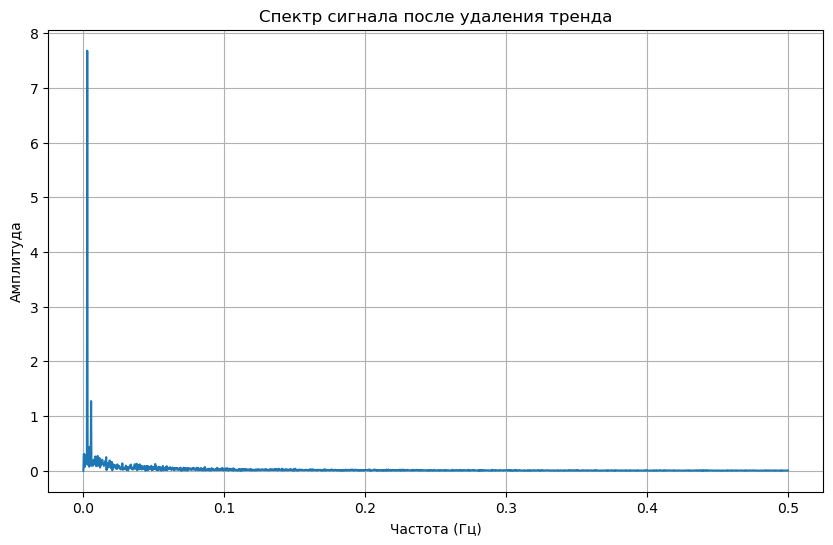

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))  #амплитудный спектр
plt.grid()
plt.title("Спектр сигнала после удаления тренда")
plt.xlabel("Частота (Гц)")
plt.ylabel("Амплитуда")
plt.show()

In [33]:
#определение значимых гармоник
threshold = 0.05 * np.max(np.abs(yf))  # Порог для значимых гармоник
significant_harmonics = np.abs(yf[:N//2]) > threshold
print(f"Частоты значимых гармоник: {xf[significant_harmonics]}")

Частоты значимых гармоник: [0.00273823 0.00383352 0.00547645]


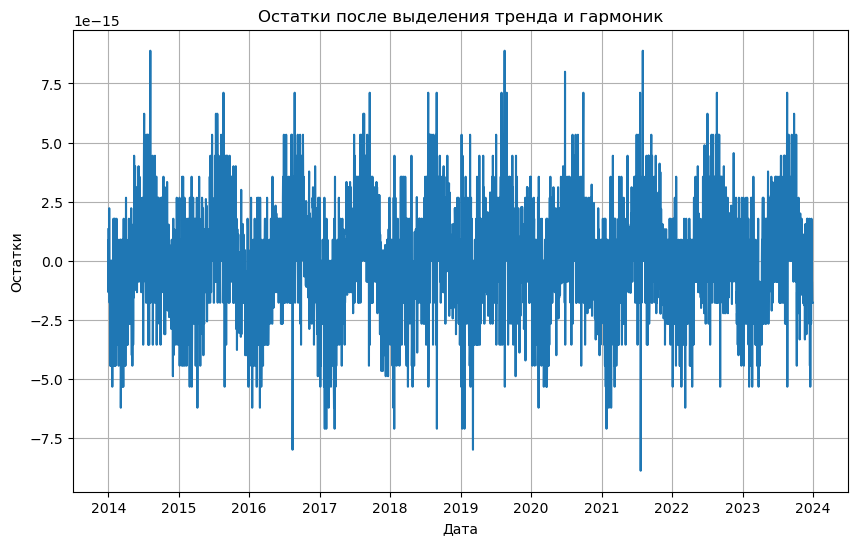

In [35]:
#4.оценка остатков (отклонение от тренда и гармоник)
residuals = values - trend - np.fft.ifft(yf).real 

plt.figure(figsize=(10, 6))
plt.plot(dates, residuals)
plt.title("Остатки после выделения тренда и гармоник")
plt.xlabel("Дата")
plt.ylabel("Остатки")
plt.grid()
plt.show()

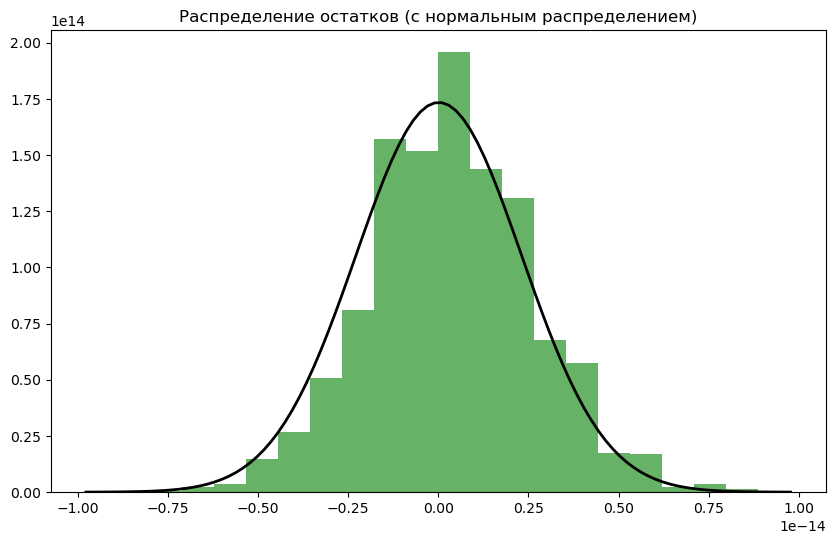

In [37]:
#проверка распределения остатков
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Распределение остатков (с нормальным распределением)")
plt.show()

In [39]:
#5.построение прогноза на год вперед
#составляем модель как сумму линейной и гармонических компонент
forecast_period = 365  #1 год 
future_dates = pd.date_range(dates.iloc[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D')

#генерация прогноза 
forecast_trend = np.column_stack([np.ones(forecast_period), np.arange(N, N + forecast_period)])
forecast_trend_values = np.dot(forecast_trend, model.params)
forecast_harmonics = np.fft.ifft(yf).real[:forecast_period] 
forecast = forecast_trend_values + forecast_harmonics

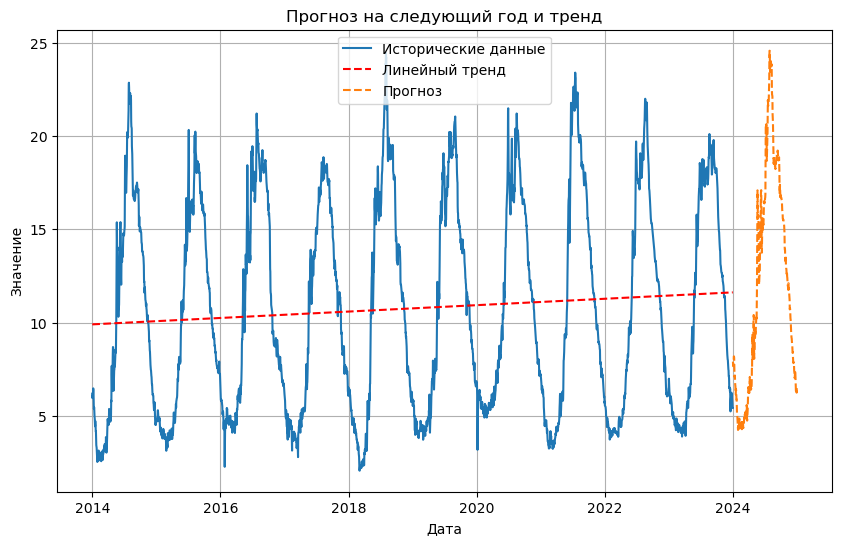

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(dates, values, label="Исторические данные")
plt.plot(dates, trend, label="Линейный тренд", linestyle='--', color='red')
plt.plot(future_dates, forecast, label="Прогноз", linestyle='--')
plt.title("Прогноз на следующий год и тренд")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.legend()
plt.grid()
plt.show()